In [1]:
# Loading important libraries

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
## Loading train data 
train_subset = pd.read_csv("train_subset.csv")

## Loading test data
test = pd.read_csv("test.csv")

## Loading location data
location_details = pd.read_excel("location_details.xlsx")

## Loading item data
item_details = pd.read_excel("item_details.xlsx")

In [3]:
train_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21679751 entries, 0 to 21679750
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Unnamed: 0   int64  
 1   date         object 
 2   locationId   object 
 3   item_id      object 
 4   unit_sales   float64
 5   onpromotion  bool   
dtypes: bool(1), float64(1), int64(1), object(3)
memory usage: 847.7+ MB


In [4]:
train_subset['date'] = pd.to_datetime(train_subset['date'])

In [5]:
# Merging train data with item and location data 

train_subset = pd.merge(train_subset,item_details,how = 'left', on = 'item_id')

train_subset = train_subset.rename(columns = {'locationId':'location_id'})

train_subset = pd.merge(train_subset,location_details,how = 'left', on = 'location_id')

In [6]:
#Extracting time features from train data 

train_subset['Month'] =pd.DatetimeIndex(train_subset['date']).month.astype('int8')
train_subset['Day'] =pd.DatetimeIndex(train_subset['date']).day.astype('int8')
train_subset['Week'] =pd.DatetimeIndex(train_subset['date']).weekday.astype('int8')

In [7]:
train_subset.head()

,Unnamed: 0,date,location_id,item_id,unit_sales,onpromotion,category_of_item,class,perishable,city,state,type,cluster,Month,Day,Week
0,0,2018-01-01,location_25,item_105574,12.0,False,grocery_items,class_1045,0,Kanpur,Uttar Pradesh,D,1,1,1,0
1,1,2018-01-01,location_25,item_105575,9.0,False,grocery_items,class_1045,0,Kanpur,Uttar Pradesh,D,1,1,1,0
2,2,2018-01-01,location_25,item_105857,3.0,False,grocery_items,class_1092,0,Kanpur,Uttar Pradesh,D,1,1,1,0
3,3,2018-01-01,location_25,item_108634,3.0,False,grocery_items,class_1075,0,Kanpur,Uttar Pradesh,D,1,1,1,0
4,4,2018-01-01,location_25,item_108701,2.0,True,deli_items,class_2644,1,Kanpur,Uttar Pradesh,D,1,1,1,0


In [8]:
# Dropping irrelevant columns

train_subset = train_subset.drop(['Unnamed: 0','date','item_id'],axis = 1)

In [9]:
### Removing negative values in train data 

train_subset = train_subset[(train_subset['unit_sales']>0)]

In [10]:
### Removing outliers 

Q1 = train_subset.unit_sales.quantile(0.25)
Q3 = train_subset.unit_sales.quantile(0.75)
print(Q1,Q3)


IQR = Q3 - Q1
print(IQR)

lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
print( lower_limit,upper_limit)


train_subset = train_subset[(train_subset.unit_sales < upper_limit)]

2.0 8.0
6.0
-7.0 17.0


In [11]:
## Label Encoding 


from sklearn import preprocessing
def df_lbl_enc(df):
    for c in df.columns:
        if df[c].dtype == 'object':
            lbl = preprocessing.LabelEncoder()
            df[c] = lbl.fit_transform(df[c])
            print(c)
    return df


train_subset = df_lbl_enc(train_subset)

location_id
category_of_item
class
city
state
type


In [12]:
 from sklearn.preprocessing import LabelEncoder

 lb = LabelEncoder()

 train_subset['onpromotion']= lb.fit_transform(train_subset['onpromotion'])

In [13]:
### Converting to category 


def cat_converter(df):
    for i in df.columns:
        if df[i].dtype == 'float64':
            df[i] = df[i]
        else:            
            df[i] = df[i].astype('category')
            print(i)
    return df


train_subset = cat_converter(train_subset)

location_id
onpromotion
category_of_item
class
perishable
city
state
type
cluster
Month
Day
Week


In [ ]:
#train_subset.head()

In [ ]:
#train_subset = train_subset.sample(frac = .1)

In [ ]:
#train_subset.info()

In [ ]:
#cols_to_transform = train_subset.select_dtypes(include=['category']).columns

#train_subset = pd.get_dummies(columns=cols_to_transform, data=train_subset, prefix=cols_to_transform, prefix_sep="_",drop_first=True)

In [14]:
train_subset.shape

(19356963, 13)

In [15]:
train_subset.head()

,location_id,unit_sales,onpromotion,category_of_item,class,perishable,city,state,type,cluster,Month,Day,Week
0,17,12.0,0,8,29,0,10,11,3,1,1,1,0
1,17,9.0,0,8,29,0,10,11,3,1,1,1,0
2,17,3.0,0,8,58,0,10,11,3,1,1,1,0
3,17,3.0,0,8,46,0,10,11,3,1,1,1,0
4,17,2.0,1,5,165,1,10,11,3,1,1,1,0


<AxesSubplot:>

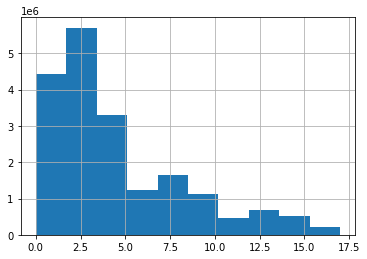

In [16]:
train_subset.unit_sales.hist()

In [17]:
# Splitting the data into train and validation. 

from sklearn.model_selection import train_test_split

X = train_subset.drop(['unit_sales'], axis = 1)

y = train_subset['unit_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [18]:
# Custom Function for MAPE(Error Metric)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
# Log transforming the target variable 

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [25]:
# Categorical Columns 

cat_cols = ['location_id','onpromotion','category_of_item','class','perishable','city','state','type','cluster','Month','Day','Week']

## LGBM

In [26]:
from lightgbm import LGBMRegressor 


## Light GBM 

LGB_model = LGBMRegressor()

LGB_model.fit(X_train, y_train_log,categorical_feature = cat_cols,verbose = 0)

# Prediction 

LGB_Model_Y_train_pred = LGB_model.predict(X_train)
LGB_Model_Y_test_pred = LGB_model.predict(X_test)


LGB_Model_Y_train_pred =np.expm1(LGB_Model_Y_train_pred)
LGB_Model_Y_test_pred =np.expm1(LGB_Model_Y_test_pred)

Train_score_LGB= mean_absolute_percentage_error(y_train,LGB_Model_Y_train_pred)
Test_score_LGB = mean_absolute_percentage_error(y_test,LGB_Model_Y_test_pred)

print(Train_score_LGB)
print(Test_score_LGB)

82.58407165058243
82.83295288281495


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

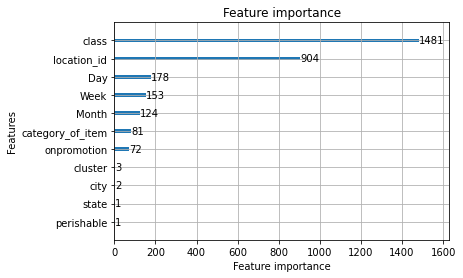

In [30]:
## Feature importance 

import lightgbm

lightgbm.plot_importance(LGB_model)

### Test Data Prep

In [ ]:
test.info()

In [ ]:
test['date'] = pd.to_datetime(test['date'])

In [ ]:
test = pd.merge(test,item_details,how = 'left', on = 'item_id')

test = test.rename(columns = {'locationId':'location_id'})

test = pd.merge(test,location_details,how = 'left', on = 'location_id')

In [ ]:
test['Month'] =pd.DatetimeIndex(test['date']).month.astype('int8')
test['Day'] =pd.DatetimeIndex(test['date']).day.astype('int8')
test['Week'] =pd.DatetimeIndex(test['date']).weekday.astype('int8')

In [ ]:
test.head()

In [ ]:
ID = test['id']

In [ ]:
test = test.drop(['id','date','item_id','state'],axis = 1)

In [ ]:
test = df_lbl_enc(test)

In [ ]:
test['onpromotion']= lb.fit_transform(test['onpromotion'])

In [ ]:
test = cat_converter(test)

In [ ]:
test.info()

In [ ]:
test.head()

In [ ]:
Test_pred = RF_model.predict(test)

In [ ]:
Test_pred

In [ ]:
Test_Pred_best = np.expm1(Test_pred)

In [ ]:
Test_Pred_best

In [ ]:
res = pd.DataFrame(Test_Pred_best)
ID = pd.DataFrame(ID)

In [ ]:
res = res.rename(columns={res.columns[0]: 'unit_sales'})

In [ ]:
gb = pd.concat([ID,res], axis = 1)

In [ ]:
gb

In [ ]:
gb['unit_sales'] = gb['unit_sales'].round(2)

In [ ]:
gb.to_csv("submission_4.csv",index= False)